#Bank Customer Churn Prediction
This project aims to predict the customers who might leave the bank based on the historical data provided.

#The Work Plan
Two pipelines are investigated: 1) Short Pipeline and 2) Long Pipeline with different preprocessing steps.


1.   **Short Pipeline (described in this file)**

  * Reading the dataset.
  * Splitting the data into training data (historical data) and testing data (future data).
  * Encoding the categorical features including the ordinal and not ordinal ones.
  * Modelling: 
      * Automatic tunning using Bayesian optimisation.
      * Cross-validation to check the generalisation error.
      * Training then evaluating the XGB classifier using different metrics. 

  * Results Discussion

2.   Long Pipeline (described in the second file)

  * Reading the dataset.
  * Splitting the data into training data (historical data) and testing data (future data).
  * Encoding the categorical features including the ordinal and not ordinal ones.
  * Imputations.
  * One-Hot Encoding.
  * Analysing the dataset (Descriptive statistics, Checking the correlation).
  * Standardisation.
  * Modelling: 
      * Automatic tunning using Bayesian optimisation.
      * Cross-validation to check the generalisation error.
      * Training then evaluating different classifiers using different metrics. 
  * Results Discussion

* Questions & Answers






In [1]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=f008599a776dd283c22175fc31ebe466d2dd84ffa0ed5294af398d299d8c97ee
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score,log_loss, confusion_matrix,classification_report, jaccard_score, \
                              f1_score, cohen_kappa_score
from sklearn.model_selection import cross_validate
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import make_scorer
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


#Short Pipline


#Reading the dataset

In [18]:
# Making a list of missing value types
missing_values = ["Unknown","n/a", "na", "--"]

df = pd.read_csv('BankChurners.csv', na_values = missing_values)
df = df.iloc[:,1:-1]
print(df.shape)
df.head(2)

(10127, 20)


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


#Splitting the Dataset 

In [4]:
# divide the dataset into 70% train and 30% test sets 
df_train, df_test = train_test_split(df,test_size= 0.3, random_state=7)
print(df_train.shape)
print(df_test.shape)

(7088, 20)
(3039, 20)


In [5]:
df_train = df_train.copy()
df_test = df_test.copy()

In [6]:
df_train.dtypes

Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

#Encoding the columns values
There are many ways to encode the columns, I chose this simple one that considers the ordinal featuers.

In [7]:
# Ordinal Number Encoding
# Encoding the training set
AttritionDict =   {'Existing Customer':0,
                    'Attrited Customer':1}

EduDict =   {'Uneducated':1,
             'High School':2,
             'College': 3,
             'Graduate': 4,
             'Doctorate': 5,
             'Post-Graduate': 6 }

MaritalDict =   {'Single':1,
                    'Married':2,
                    'Divorced':3}

IncomeDict =   {'Less than $40K':1,
             '$40K - $60K':2,
             '$60K - $80K': 3,
             '$80K - $120K': 4,
             '$120K +': 5}

CardDict =   {'Blue':1,
             'Silver':2,
             'Gold': 3,
             'Platinum': 4 }


df_train['Attrition_Flag'] = df_train['Attrition_Flag'].map(AttritionDict)

df_train['Education_Level'] = df_train['Education_Level'].map(EduDict)

df_train['Marital_Status'] = df_train['Marital_Status'].map(MaritalDict)

df_train['Income_Category'] = df_train['Income_Category'].map(IncomeDict)

df_train['Card_Category'] = df_train['Card_Category'].map(CardDict)


# Encoding of unordinal feature 'Gender'
enc = LabelEncoder()
enc.fit(df_train['Gender'])
df_train['Gender'] = enc.transform(df_train['Gender'])



In [8]:
# Encoding the test set (future data)
df_test['Attrition_Flag'] = df_test['Attrition_Flag'].map(AttritionDict)

df_test['Education_Level'] = df_test['Education_Level'].map(EduDict)

df_test['Marital_Status'] = df_test['Marital_Status'].map(MaritalDict)

df_test['Income_Category'] = df_test['Income_Category'].map(IncomeDict)

df_test['Card_Category'] = df_test['Card_Category'].map(CardDict)

enc = LabelEncoder()
enc.fit(df_test['Gender'])
df_test['Gender'] = enc.transform(df_test['Gender'])

#Modelling

In [9]:
# extract the training input features and the target feature
y_train = df_train['Attrition_Flag']
x_train = df_train.drop('Attrition_Flag', axis=1)

# extract the testing input features and the target feature
y_test = df_test['Attrition_Flag']
x_test = df_test.drop('Attrition_Flag', axis=1)



In [10]:
# define a function for cross-valdation
kappa_scorer = make_scorer(cohen_kappa_score)
f1_scorer = make_scorer(f1_score)

@ignore_warnings(category=ConvergenceWarning)
def cross_valid_fun(model, features, target, cv, scorer):
  cv_results = cross_validate(model, features, target, cv=cv, scoring=scorer)
  CV_mean = cv_results['test_score'].mean()
  CV_std = cv_results['test_score'].std()
  return CV_mean, CV_std

In [11]:
# define function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
# define a function for printing the metrices
def metrics(y_test, y_hat, y_prob):
  # extract the model accuracy
  print("Accuracy : {:.2%}".format(accuracy_score(y_test, y_hat)))
  # F1
  print("F1 : {:.2%}".format(f1_score(y_test, y_hat)))
  # extract jaccard score
  print("Jaccard : {:.2f}".format(jaccard_score(y_test,y_hat)))
  # Kappa
  print("Kappa : {:.2f}".format(cohen_kappa_score(y_test, y_hat)))
  # extract the log loss metric
  print("log_loss : {:.2f}".format(log_loss(y_test, y_prob)),'\n')

  # extract the classification report
  print(classification_report(y_test,y_hat))    


  # Compute confusion matrix
  cnf_matrix = confusion_matrix(y_test, y_hat, labels=[0,1])
  # Plot non-normalized confusion matrix
  sns.set(font_scale=1)
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=['churn=0','churn=1'],normalize= False,  title='Confusion matrix')

#Tunning

In [13]:
from bayes_opt import BayesianOptimization

def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha):
    from sklearn.metrics import roc_auc_score
    import numpy as np
    
    estimator_function = XGBClassifier(max_depth=int(max_depth),
                                           learning_rate= learning_rate,
                                           n_estimators= int(n_estimators),
                                           reg_alpha = reg_alpha,
                                           nthread = -1,
                                           objective='binary:logistic',
                                           seed = seed)
    
    x_train_temp, x_val_temp , y_train_temp, y_val_temp = train_test_split(x_train,y_train, test_size= 0.3, random_state=7)
    # Fit the estimator
    estimator_function.fit(x_train_temp, y_train_temp)
    
    y_hat = estimator_function.predict(x_val_temp)
    kappa_val = cohen_kappa_score(y_val_temp, y_hat)
      
    return np.array(kappa_val)

gp_params = {"alpha": 1e-10}

seed = 112 # Random seed

hyperparameter_space = {
    'max_depth': (5, 100),
    'learning_rate': (0, 1),
    'n_estimators' : (10,1000),
    'reg_alpha': (0,1)
}


xgbcBO = BayesianOptimization(f = xgbc_cv, 
                             pbounds =  hyperparameter_space,
                             random_state = seed,
                             verbose = 10)

xgbcBO.maximize(init_points=3,n_iter=30,acq='ucb', kappa= 3, **gp_params)

|   iter    |  target   | learni... | max_depth | n_esti... | reg_alpha |
-------------------------------------------------------------------------
|  1        |  0.8699   |  0.3751   |  65.83    |  950.5    |  0.07568  |
|  2        |  0.8602   |  0.7769   |  84.11    |  64.26    |  0.8177   |
|  3        |  0.8737   |  0.8854   |  73.62    |  12.53    |  0.9812   |
|  4        |  0.8844   |  0.2503   |  5.015    |  491.7    |  0.1215   |
|  5        |  0.8911   |  0.103    |  5.178    |  990.7    |  0.595    |
|  6        |  0.8172   |  0.1339   |  5.265    |  15.0     |  0.6709   |
|  7        |  0.8886   |  0.2149   |  5.167    |  994.4    |  0.9304   |
|  8        |  0.8894   |  0.356    |  5.062    |  743.2    |  0.8687   |
|  9        |  0.8842   |  0.1559   |  99.95    |  505.3    |  0.8803   |
|  10       |  0.8573   |  0.6787   |  99.54    |  326.2    |  0.3244   |
|  11       |  0.8693   |  0.9743   |  5.336    |  876.3    |  0.08744  |
|  12       |  0.8861   |  0.06789  | 

#Cross-Validation

In [14]:
XGB = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.03979,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=679, 
                      reg_alpha = 0.04511,
                      max_depth=5, 
                      gamma=10)
CV_mean_Kappa, CV_std_Kappa = cross_valid_fun(XGB, x_train, y_train, 10, kappa_scorer)
CV_mean_F1, CV_std_F1 = cross_valid_fun(XGB, x_train, y_train, 10, f1_scorer)

print("Kappa mean:{:.2f} std:{:.2f}".format(CV_mean_Kappa, CV_std_Kappa))
print("F1 mean:{:.2%} std:{:.2%}".format(CV_mean_F1, CV_std_F1))

Kappa mean:0.88 std:0.03
F1 mean:89.76% std:2.17%


#Train-Test using XGB Classifier

Accuracy : 96.87%
F1 : 89.41%
Jaccard : 0.81
Kappa : 0.88
log_loss : 0.09 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2573
           1       0.93      0.86      0.89       466

    accuracy                           0.97      3039
   macro avg       0.95      0.92      0.94      3039
weighted avg       0.97      0.97      0.97      3039



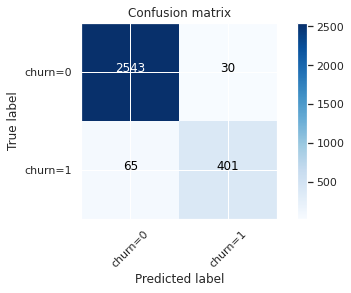

In [15]:
XGB = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.4434,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=750, 
                      reg_alpha = 0.9185,
                      max_depth=6, 
                      gamma=10)

XGB.fit(x_train, y_train)
y_hat = XGB.predict(x_test)
y_prob = XGB.predict_proba(x_test)

metrics(y_test, y_hat, y_prob)

#Imoratnace of the Features

In [16]:
features = [c for c in df_train.columns if c != "Attrition_Flag"]
feature_df = pd.DataFrame()
feature_df['label'] = features
feature_df['importance'] = XGB.feature_importances_
feature_df.sort_values(by='importance', ascending=False)

,label,importance
17,Total_Ct_Chng_Q4_Q1,0.167563
18,Avg_Utilization_Ratio,0.144575
16,Total_Trans_Ct,0.111337
12,Total_Revolving_Bal,0.094621
8,Total_Relationship_Count,0.090479
15,Total_Trans_Amt,0.057647
9,Months_Inactive_12_mon,0.049475
1,Gender,0.048474
10,Contacts_Count_12_mon,0.046548
11,Credit_Limit,0.034832


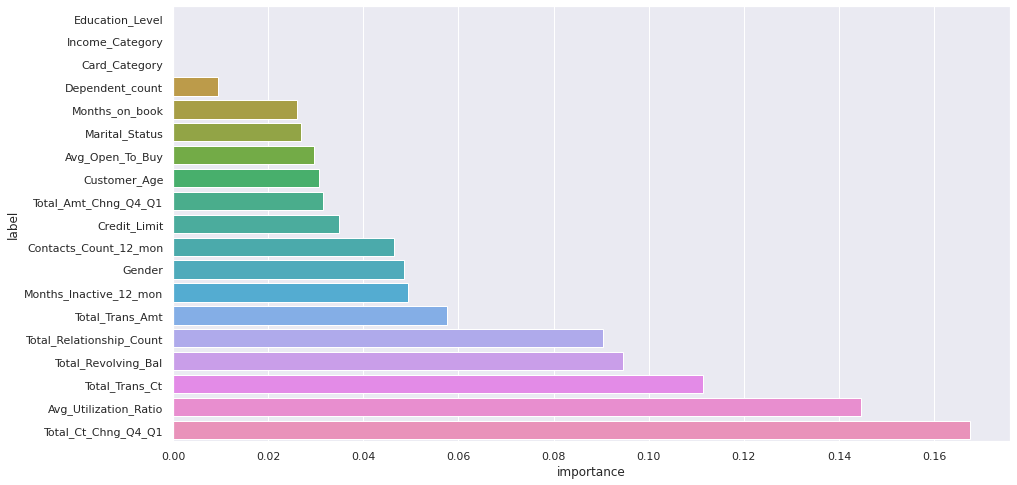

In [17]:
plt.figure(figsize=(15,8))
sns.barplot(y="label",x="importance",order=feature_df.sort_values("importance").label,data=feature_df)

#Results

This pipeline requires less pre-processing effort and provides very good results. In the second file, we will see that these results are better than the results using other machine learning techniques that require more effort.